In [1]:
import torch
import pandas as pd
import numpy as np
import pickle, logging, spacy, sys, os, json, requests
import matplotlib.pyplot as plt

from helpers.classes import Collection
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime

In [2]:
from helpers.cloze_generation import generate_clozes_from_point, named_entity_answer_generator as ne_answer_generator, noun_phrase_answer_generator as np_answer_generator

from helpers.table_processing import preprocess_table, read_process_table, find_relevant_column_header, find_relevant_content
from helpers.t5_language_model import summarise_t5_results


df = pd.read_pickle('pickles/dataset_20210625_184837.pkl')
clozes_df = pd.read_json('pickles/clozes_20210807_165700.json')
clozes_df2 = pd.read_json('pickles/clozes_20210715_212425.json')

In [3]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('fivethirtyeight')

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [4]:
clozes_df

,ids,cloze_text,source_text,answer_text,answer_type,data
0,ccf75a2c157eacc5253f0e8a55b1ded9f5386d58,"In<mask>, approximate gross value added at bas...","In 2019, approximate gross value added at basi...",2019,DATE,[/businessindustryandtrade/business/businessse...
1,fc3346f2545ca5059bdb5150b998300c5001bea5,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","£1,313.9 billion",MONEY,[/businessindustryandtrade/business/businessse...
2,81aa32270d547a368e7b806646c72069ba4fac43,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",£42.8 billion,MONEY,[/businessindustryandtrade/business/businessse...
3,f308eb661ad1d6c8021cf9e22d8e8c7d9c5ff50e,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",3.4%,PERCENT,[/businessindustryandtrade/business/businessse...
4,0a0bcf4b990f1926bc87fa662badadaf7e23d5fa,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",2018,DATE,[/businessindustryandtrade/business/businessse...
...,...,...,...,...,...,...
4085,58116a07356fb4b001d48629d7864909c03fab79,Children who reported “low” satisfaction with ...,Children who reported “low” satisfaction with ...,28.3%,PERCENT,[/peoplepopulationandcommunity/wellbeing/datas...
4086,9902578d5ee75716bec570af2ae7ca8c378f039a,Children who reported “low” satisfaction with ...,Children who reported “low” satisfaction with ...,about 10%,PERCENT,[/peoplepopulationandcommunity/wellbeing/datas...
4087,2124dac9b26f153e90758d9f9f95d51c7aaeebef,9.8% of young people said that they were “ofte...,9.8% of young people said that they were “ofte...,9.8%,PERCENT,[/peoplepopulationandcommunity/wellbeing/datas...
4088,059317f10fe57b868e10900dd413e48a852ed0b3,Those reporting no long-term illness or disabi...,Those reporting no long-term illness or disabi...,44.8%,PERCENT,[/peoplepopulationandcommunity/wellbeing/datas...


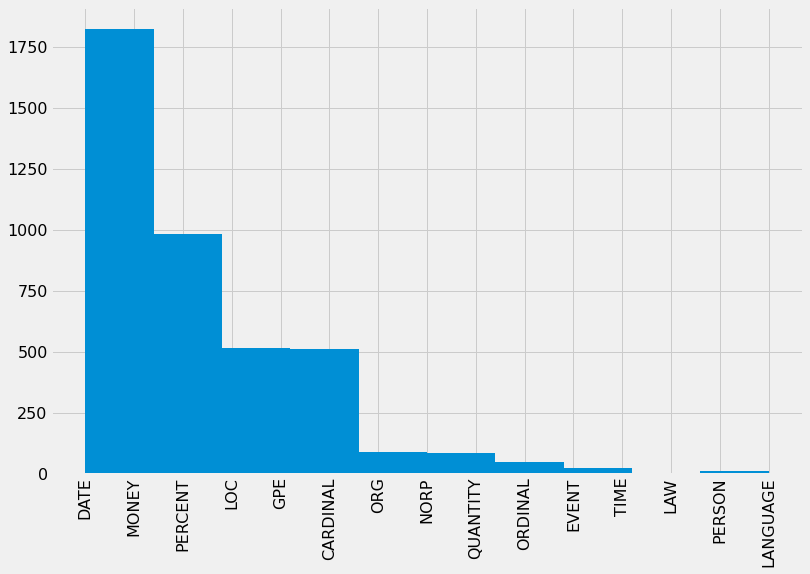

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.hist(clozes_df.answer_type)
plt.xticks(rotation = 90)
plt.show()

In [6]:
source_lengths = [len(x) for x in clozes_df.source_text]

(array([ 38., 140., 327., 520., 559., 749., 796., 626., 282.,  53.]),
 array([ 43. ,  66.6,  90.2, 113.8, 137.4, 161. , 184.6, 208.2, 231.8,
        255.4, 279. ]),
 <BarContainer object of 10 artists>)

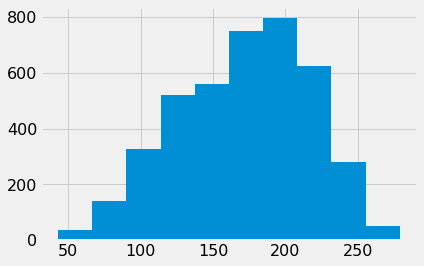

In [7]:
plt.hist(source_lengths)

In [8]:
[(x,y) for x, y in zip(clozes_df.source_text, clozes_df.cloze_text) if len(x) < 100]

[('London had both the highest business birth rate at 15.7%, and death rate at 13.1%.',
  'London had both the highest business birth rate at 15.7%, and death rate at 13.1%<mask> had both the highest business birth rate at 15.7%, and death rate at 13.1%.'),
 ('London had both the highest business birth rate at 15.7%, and death rate at 13.1%.',
  'London had both the highest business birth rate at<mask><mask><mask><mask>, and death rate at 13.1%.'),
 ('London had both the highest business birth rate at 15.7%, and death rate at 13.1%.',
  'London had both the highest business birth rate at 15.7%, and death rate at<mask><mask><mask><mask>.'),
 ('92% of adults in the UK were recent internet users in 2020, up from 91% in 2019.',
  '92% of adults in the UK were recent internet users in 2020, up from 91% in 2019<mask><mask> of adults in the UK were recent internet users in 2020, up from 91% in 2019.'),
 ('92% of adults in the UK were recent internet users in 2020, up from 91% in 2019.',
  '92

In [9]:
clozes_df[clozes_df.source_text.apply(len) < 100]

,ids,cloze_text,source_text,answer_text,answer_type,data
65,a2dc210f0e91ee96a8f56f1422031d076d00d542,London had both the highest business birth rat...,London had both the highest business birth rat...,London,GPE,[/businessindustryandtrade/business/activitysi...
66,2d4dc965eb1c2c4c0d4c8d483ff4b861517d7cc9,London had both the highest business birth rat...,London had both the highest business birth rat...,15.7%,PERCENT,[/businessindustryandtrade/business/activitysi...
67,092bf007c874f1c82df37a9eaa9443f9f23cf654,London had both the highest business birth rat...,London had both the highest business birth rat...,13.1%,PERCENT,[/businessindustryandtrade/business/activitysi...
192,fd131f791b03aa737423ef6ba2034e35ea34c6b4,92% of adults in the UK were recent internet u...,92% of adults in the UK were recent internet u...,92%,PERCENT,[/businessindustryandtrade/itandinternetindust...
193,15d87287066394c2d2f5705ca6791ababce93bd3,92% of adults in the UK were recent internet u...,92% of adults in the UK were recent internet u...,2020,DATE,[/businessindustryandtrade/itandinternetindust...
...,...,...,...,...,...,...
3927,88a872b3ef257b84b0fcd986ee6432c23433bdfb,"784,900<mask> citizens live in the EU, excludi...","784,900 British citizens live in the EU, exclu...",British,NORP,[/peoplepopulationandcommunity/populationandmi...
3928,a8dbf063f12b6995e6550d7d6217c83f0c899f19,"784,900 British citizens live in the EU, exclu...","784,900 British citizens live in the EU, exclu...",Ireland,GPE,[/peoplepopulationandcommunity/populationandmi...
3929,089a5b55e413223b3550318d84be96fa5d472670,"784,900 British citizens live in the EU, exclu...","784,900 British citizens live in the EU, exclu...",1 January 2017,DATE,[/peoplepopulationandcommunity/populationandmi...
3993,b1a03e27f181da789ffc8bc67c22241fb0efd577,Over the period<mask><mask><mask><mask><mask><...,Over the period 27 January to 7 March 2021:,27 January to 7 March 2021,DATE,[/peoplepopulationandcommunity/wellbeing/datas...


In [10]:
clozes_df.iloc[65].cloze_text

'London had both the highest business birth rate at 15.7%, and death rate at 13.1%<mask> had both the highest business birth rate at 15.7%, and death rate at 13.1%.'

In [11]:
clozes_df.iloc[65].source_text

'London had both the highest business birth rate at 15.7%, and death rate at 13.1%.'

In [15]:
clozes_df2.iloc[73].cloze_text

'London had both the highest business birth rate at 15.7%, and death rate at 13.1%<mask> had both the highest business birth rate at 15.7%, and death rate at 13.1%.'

In [21]:
sav = generate_clozes_from_point(clozes_df2.iloc[73].source_text, ne_answer_generator)

In [22]:
next(sav)

Cloze(cloze_id='a2dc210f0e91ee96a8f56f1422031d076d00d542', source_text=London had both the highest business birth rate at 15.7%, and death rate at 13.1%., source_start=0, cloze_text='PLACEMASK had both the highest business birth rate at 15.7%, and death rate at 13.1%.', answer_text='London', answer_start=0, constituency_parse=None, root_label=None, answer_type='GPE', question_text=None)

In [46]:
clozes_df.iloc[65]

ids                     a2dc210f0e91ee96a8f56f1422031d076d00d542
cloze_text     London had both the highest business birth rat...
source_text    London had both the highest business birth rat...
answer_text                                               London
answer_type                                                  GPE
data           [/businessindustryandtrade/business/activitysi...
Name: 65, dtype: object

In [24]:
from helpers.cloze_generation import mask_answer

In [25]:
mask_answer('London had both the highest business birth rate at 15.7%, and death rate at 13.1%.', 'London', 0, 'GPE')

'PLACEMASK had both the highest business birth rate at 15.7%, and death rate at 13.1%.'